# Self-Driving Car Engineer Nanodegree

## Deep Learning

## Project: Build a Traffic Sign Recognition Classifier

In this notebook, a template is provided for you to implement your functionality in stages, which is required to successfully complete this project. If additional code is required that cannot be included in the notebook, be sure that the Python code is successfully imported and included in your submission if necessary. 

> **Note**: Once you have completed all of the code implementations, you need to finalize your work by exporting the iPython Notebook as an HTML document. Before exporting the notebook to html, all of the code cells need to have been run so that reviewers can see the final implementation and output. You can then export the notebook by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission. 

In addition to implementing code, there is a writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) that can be used to guide the writing process. Completing the code template and writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/481/view) for this project.

The [rubric](https://review.udacity.com/#!/rubrics/481/view) contains "Stand Out Suggestions" for enhancing the project beyond the minimum requirements. The stand out suggestions are optional. If you decide to pursue the "stand out suggestions", you can include the code in this Ipython notebook and also discuss the results in the writeup file.


>**Note:** Code and Markdown cells can be executed using the **Shift + Enter** keyboard shortcut. In addition, Markdown cells can be edited by typically double-clicking the cell to enter edit mode.

---
## Step 0: Load The Data

In [1]:
import os
import sys
import shutil
import uuid
import random
import csv
import json
import contextlib
from itertools import chain

import numpy as np
import tensorflow as tf
from operator import attrgetter, itemgetter
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.utils import shuffle
from tensorflow.contrib.layers import flatten

from PIL import Image
import cv2
import matplotlib as mpl
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
# Visualizations will be shown in the notebook.
%matplotlib inline

from IPython.display import HTML, display

In [2]:
# Load pickled data
import pickle

# TODO: Fill this in based on where you saved the training and testing data

training_file = "traffic-signs-data/train.p"
validation_file = "traffic-signs-data/valid.p"
testing_file = "traffic-signs-data/test.p"

with open(training_file, mode='rb') as f:
    train = pickle.load(f)
with open(validation_file, mode='rb') as f:
    valid = pickle.load(f)
with open(testing_file, mode='rb') as f:
    test = pickle.load(f)

# Cast features data to float32
def to_float(d):
    return d.astype(np.float32)

X_train_src, y_train_src = to_float(train['features']), train['labels']
X_valid, y_valid = to_float(valid['features']), valid['labels']
X_test, y_test = to_float(test['features']), test['labels']

X_valid_visualization = X_valid.copy()
X_test_visualization = X_test.copy()

In [3]:
# Create temporary folder for rendered images
TEMP_DIR = 'tmp'
if os.path.exists(TEMP_DIR):
    shutil.rmtree(TEMP_DIR)
os.mkdir(TEMP_DIR)

---

## Step 1: Dataset Summary & Exploration

The pickled data is a dictionary with 4 key/value pairs:

- `'features'` is a 4D array containing raw pixel data of the traffic sign images, (num examples, width, height, channels).
- `'labels'` is a 1D array containing the label/class id of the traffic sign. The file `signnames.csv` contains id -> name mappings for each id.
- `'sizes'` is a list containing tuples, (width, height) representing the original width and height the image.
- `'coords'` is a list containing tuples, (x1, y1, x2, y2) representing coordinates of a bounding box around the sign in the image. **THESE COORDINATES ASSUME THE ORIGINAL IMAGE. THE PICKLED DATA CONTAINS RESIZED VERSIONS (32 by 32) OF THESE IMAGES**

Complete the basic data summary below. Use python, numpy and/or pandas methods to calculate the data summary rather than hard coding the results. For example, the [pandas shape method](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.DataFrame.shape.html) might be useful for calculating some of the summary results. 

### Provide a Basic Summary of the Data Set Using Python, Numpy and/or Pandas

In [4]:
### Replace each question mark with the appropriate value. 
### Use python, pandas or numpy methods rather than hard coding the results

# TODO: Number of validation examples
n_validation = y_valid.shape[0]

# TODO: Number of testing examples.
n_test = y_test.shape[0]

# TODO: What's the shape of an traffic sign image?
image_shape = X_train_src[0].shape

# TODO: How many unique classes/labels there are in the dataset.
n_classes = len(set(y_train_src) | set(y_valid) | set(y_test))

print("Number of training examples =", y_train_src.shape[0])
print("Number of validation examples =", n_validation)
print("Number of testing examples =", n_test)
print("Image data shape =", image_shape)
print("Number of classes =", n_classes)

Number of training examples = 34799
Number of validation examples = 4410
Number of testing examples = 12630
Image data shape = (32, 32, 3)
Number of classes = 43


In [5]:
# Load signnames.csv

sign_names = []
with open('signnames.csv') as f:
    f.readline()  # Skip header
    csv_reader = csv.reader(f)
    # To avoid assuming any order of items in CSV, load data in a dictionary first
    # and then put names into list
    sign_names_dict = {int(idx):name for idx, name in csv_reader}
    sign_names = [sign_names_dict.get(i) for i in range(n_classes)]

# Print class names
#for entry in enumerate(sign_names):
#    print("{}: {}".format(*entry))

### Include an exploratory visualization of the dataset

Visualize the German Traffic Signs Dataset using the pickled file(s). This is open ended, suggestions include: plotting traffic sign images, plotting the count of each sign, etc. 

The [Matplotlib](http://matplotlib.org/) [examples](http://matplotlib.org/examples/index.html) and [gallery](http://matplotlib.org/gallery.html) pages are a great resource for doing visualizations in Python.

**NOTE:** It's recommended you start with something simple first. If you wish to do more, come back to it after you've completed the rest of the sections. It can be interesting to look at the distribution of classes in the training, validation and test set. Is the distribution the same? Are there more examples of some classes than others?

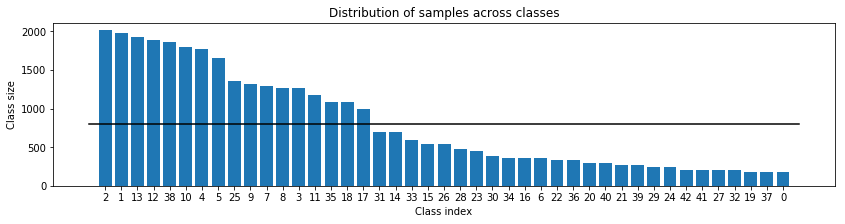

In [6]:
### Data exploration visualization code goes here.
### Feel free to use as many code cells as needed.

# Count samples in each class
def count_samples(labels):
    sz = np.zeros([n_classes])
    for class_idx in range(n_classes):
        sz[class_idx] = np.count_nonzero(labels == class_idx)
    return sz

def plot_distribution(data_set, title=None, threshold=None):
    class_size = count_samples(data_set)

    # Sort
    sorted_indices = np.flip(class_size.argsort(), axis=0)

    # Draw bar chart, ordering classes by class size
    class_range = range(n_classes)
    plt.figure(figsize=(14, 3))
    plt.bar(class_range, class_size[sorted_indices])
    plt.xticks(class_range, sorted_indices)
    if title:
        plt.title(title)
    if threshold:
        plt.plot((-1, n_classes), (threshold, threshold), 'k-')
    plt.ylabel("Class size")
    plt.xlabel("Class index")
    plt.show()

REDUCE_SAMPLES_TRHRESHOLD = 800.0
plot_distribution(y_train_src, "Distribution of samples across classes",
                  REDUCE_SAMPLES_TRHRESHOLD)

# Compute fraction of elements to delete from each class
# in order to reduce the number of samples in popular classes
# (delete when number of elements in class > threshold)
fraction_to_delete = 1 - np.minimum(REDUCE_SAMPLES_TRHRESHOLD / count_samples(y_train_src), 1)

#### Auxiliary functions

In [7]:
def display_table(data, header):
    """Generates HTML code for tabular data"""
    if header:
        header_str = "<tr><th>{}</th></tr>".format("</th><th>".join(header))
    else:
        header_str = ""
    display(HTML("<table>{}<tr>{}</tr></table>".format(header_str, "</tr><tr>".join(
            "<td>{}</td>".format("</td><td>".join(str(_) for _ in row)) for row in data))))

def get_link(image, dpi=None):
    """Renders image into a temporary folder and generates HTML link to it"""
    file_path = os.path.join(TEMP_DIR, str(uuid.uuid4()) + ".png")
    saved_dpi, mpl.rcParams['figure.dpi'] = mpl.rcParams['figure.dpi'], dpi or mpl.rcParams['figure.dpi']
    plt.figure(figsize=(1,1))
    fig = plt.imshow(image.astype(np.uint8))
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    plt.savefig(file_path)
    plt.close()
    mpl.rcParams['figure.dpi'] = saved_dpi
    return "<img src='{}'></img>".format(file_path)

def show_sign_images(data, labels, indices, header=None, notes=None, notes2=None, dpi=None):
    """Displys images in an HTML table"""
    rows = []
    for row_index, data_index in enumerate(indices):
        image = data[data_index]
        row_data = [str(row_index + 1), get_link(image, dpi), sign_names[labels[data_index]]]
        if notes:
            row_data.append("<br>".join([c for c in notes[row_index]]))
        if notes2:
            row_data.append("<br>".join([c for c in notes2[row_index]]))
        rows.append(row_data)
    if header:
        header = chain([""], header)
    display_table(rows, header)

# show_sign_images(X_train_src, y_train_src, [random.randint(0, len(X_train_src))])

In [8]:
def images_to_numpy(images):
    """Converts list of images to a single numpy array"""
    # Converts list of images to nd.array
    result = None
    for im in images:
        np_arr = np.copy(im)
        # Remove alpha channel
        np_arr = np_arr[:, :, 0:3]
        # Convert to 4-dimension
        np_arr = np.expand_dims(np_arr, axis=0)

        if result is None:
            result = np_arr
        else:
            result = np.append(result, np_arr, axis=0)
    return result

In [9]:
PREPROCESSED_DIR = 'preprocessed'
if not os.path.exists(PREPROCESSED_DIR):
    os.mkdir(PREPROCESSED_DIR)

In [10]:
def generate_noise():
    """Adds noise to a copy of the training data set."""

    NOISE_FILE = os.path.join(PREPROCESSED_DIR, "noise.p")
    NOISE_LEVEL = 30

    try:
        with open(NOISE_FILE, mode='rb') as f:
            X_train_noise = pickle.load(f)
    except:
        print("Generating noise...")
        X_train_noise = np.float32(X_train_src.copy())
        noise = np.random.uniform(low=-NOISE_LEVEL, high=NOISE_LEVEL, size=X_train_noise.shape)

        X_train_noise = X_train_noise + noise
        X_train_noise = np.minimum(np.maximum(0, X_train_noise), 255)
        X_train_noise = X_train_noise.astype(np.uint8)

        with open(NOISE_FILE, mode='wb') as f:
            pickle.dump(X_train_noise, f)

    return X_train_noise, y_train_src

In [11]:
def generate_scaled_colors():
    """Scales color values in a copy of the training data set."""

    COLORS_FILE = os.path.join(PREPROCESSED_DIR, "colors.p")

    try:
        with open(COLORS_FILE, mode='rb') as f:
            X_train_scale = pickle.load(f)
    except:
        # Randomly scale colors
        print("Scaling colors...")
        X_train_scale = X_train_src.copy()
        scale_f = np.random.uniform(low=0.3, high=0.5, size=X_train_scale.shape[0])
        scale_f = scale_f.astype(np.float32)
        # Scale range: [0.4, 0.6] U [1.5, 1.7]
        scale_f = scale_f + 0.1 + 1.2 * (np.average(X_train_src, axis=(1, 2, 3)) < 150)

        for i in range(X_train_scale.shape[0]):
            X_train_scale[i] = X_train_scale[i] * scale_f[i]
        X_train_scale = np.minimum(np.maximum(0, X_train_scale), 255)
        X_train_scale = X_train_scale.astype(np.uint8)

        with open(COLORS_FILE, mode='wb') as f:
            pickle.dump(X_train_scale, f)
    
    return X_train_scale, y_train_src

In [12]:
def zoom_in(new_size):
    """Zooms in images in a copy of the training data set."""
    
    ZOOM_FILE = os.path.join(PREPROCESSED_DIR, "zoom{}.p".format(new_size))

    # Include only every n-th image in the final dataset
    ZOOM_SKIP_STEP = 1

    try:
        with open(ZOOM_FILE, mode='rb') as f:
            X_train_zoom = pickle.load(f)
    except:
        print("Zooming in images (may take a while)...")
    
        im_list = []
        for el in X_train_src[::ZOOM_SKIP_STEP]:
            im = Image.fromarray(np.uint8(el), 'RGB')
            im_resized = im.resize((new_size, new_size), Image.BICUBIC)
            im_list.append(im_resized)
        X_train_zoom = images_to_numpy(im_list)

        slices_to_delete = []
        for n in range(int((new_size - 32) / 2)):
            slices_to_delete.append(n)
            slices_to_delete.append(new_size - n - 1)
        X_train_zoom = np.delete(X_train_zoom, slices_to_delete, 1)
        X_train_zoom = np.delete(X_train_zoom, slices_to_delete, 2)
        X_train_zoom = X_train_zoom.astype(np.uint8)

        with open(ZOOM_FILE, mode='wb') as f:
            pickle.dump(X_train_zoom, f)

    return X_train_zoom, y_train_src[::ZOOM_SKIP_STEP]

In [13]:
def augment_data(noise=False, colors=False, new_size=None, visualize=False):
    """Augments training data set"""
    
    X = X_train_src.copy()
    y = y_train_src.copy()
    
    if noise:
        X_noise, y_noise = generate_noise()
        X = np.append(X, X_noise, axis=0)
        y = np.append(y, y_noise, axis=0)
        if visualize:
            show_sign_images(X_noise, y_noise, [random.randint(0, len(X_noise))])
    
    if colors:
        X_scale, y_scale = generate_scaled_colors()
        X = np.append(X, X_scale, axis=0)
        y = np.append(y, y_scale, axis=0)
        if visualize:
            show_sign_images(X_scale, y_scale, [random.randint(0, len(X_scale))])
    
    if new_size:
        X_zoom, y_zoom = zoom_in(new_size)
        X = np.append(X, X_zoom, axis=0)
        y = np.append(y, y_zoom, axis=0)
        if visualize:
            show_sign_images(X_zoom, y_zoom, [random.randint(0, len(X_zoom))])

    return X, y

In [14]:
def reduce_samples(x_data, y_data, fractions):
    n_samples_to_delete = np.uint32(count_samples(y_data) * fractions)
    indices_to_delete = None
    for class_idx, n_class_samples_to_delete in enumerate(n_samples_to_delete):
        if n_class_samples_to_delete <= 0:
            continue

        matching_indices = np.where(np.equal(y_data, class_idx))[0]
        class_indices_to_delete = shuffle(
            matching_indices, n_samples=n_class_samples_to_delete)

        if indices_to_delete is None:
            indices_to_delete = class_indices_to_delete
        else:
            indices_to_delete = np.append(indices_to_delete, class_indices_to_delete)

    x_reduced = np.delete(x_data.copy(), indices_to_delete, axis=0)
    y_reduced = np.delete(y_data.copy(), indices_to_delete, axis=0)
    
    return x_reduced, y_reduced

In [15]:
def trim_label(label, trim_at=27):
    if len(label) > trim_at:
        return label[:trim_at-3] + "..."
    else:
        return label

def show_images_row(images, titles, spacing=0.3):
    fig = plt.figure()
    for idx, (image, title) in enumerate(zip(images, titles)):
        s = fig.add_subplot(1, len(images), idx + 1,
                            position=[0 + idx * spacing, 0, 0.3, 0.3])
        im = plt.imshow(image.astype(np.uint8))
        im.axes.get_xaxis().set_visible(False)
        im.axes.get_yaxis().set_visible(False)
        s.set_title(title)
    plt.show()

----

## Step 2: Design and Test a Model Architecture

Design and implement a deep learning model that learns to recognize traffic signs. Train and test your model on the [German Traffic Sign Dataset](http://benchmark.ini.rub.de/?section=gtsrb&subsection=dataset).

The LeNet-5 implementation shown in the [classroom](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) at the end of the CNN lesson is a solid starting point. You'll have to change the number of classes and possibly the preprocessing, but aside from that it's plug and play! 

With the LeNet-5 solution from the lecture, you should expect a validation set accuracy of about 0.89. To meet specifications, the validation set accuracy will need to be at least 0.93. It is possible to get an even higher accuracy, but 0.93 is the minimum for a successful project submission. 

There are various aspects to consider when thinking about this problem:

- Neural network architecture (is the network over or underfitting?)
- Play around preprocessing techniques (normalization, rgb to grayscale, etc)
- Number of examples per label (some have more than others).
- Generate fake data.

Here is an example of a [published baseline model on this problem](http://yann.lecun.com/exdb/publis/pdf/sermanet-ijcnn-11.pdf). It's not required to be familiar with the approach used in the paper but, it's good practice to try to read papers like these.

### Pre-process the Data Set (normalization, grayscale, etc.)

Minimally, the image data should be normalized so that the data has mean zero and equal variance. For image data, `(pixel - 128)/ 128` is a quick way to approximately normalize the data and can be used in this project. 

Other pre-processing steps are optional. You can try different techniques to see if it improves performance. 

Use the code cell (or multiple code cells, if necessary) to implement the first step of your project.

Generating X_train_2...
Generating X_train_3...
Generating X_train_4...
Generating X_train_5...
Generating X_train_6...
X_train dataset size: 34799
X_train_2 dataset size: 69598
X_train_3 dataset size: 104397
X_train_4 dataset size: 139196
X_train_5 dataset size: 104397
X_train_6 dataset size: 68160


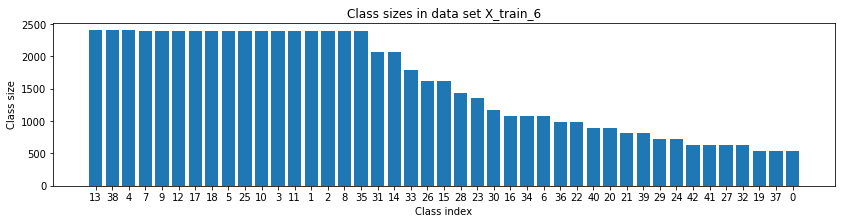

In [16]:
X_train, y_train = augment_data()  # clone source data
X_train_visualization = X_train.copy()

print("Generating X_train_2...")
X_train_2, y_train_2 = augment_data(noise=True)

print("Generating X_train_3...")
X_train_3, y_train_3 = augment_data(noise=True, colors=True)

print("Generating X_train_4...")
X_train_4, y_train_4 = augment_data(noise=True, colors=True, new_size=40, visualize=False)

print("Generating X_train_5...")
X_train_5, y_train_5 = augment_data(noise=True, new_size=40)

print("Generating X_train_6...")
X_train_6, y_train_6 = reduce_samples(X_train_5, y_train_5, fraction_to_delete)

print("X_train dataset size: {}".format(X_train.shape[0]))
print("X_train_2 dataset size: {}".format(X_train_2.shape[0]))
print("X_train_3 dataset size: {}".format(X_train_3.shape[0]))
print("X_train_4 dataset size: {}".format(X_train_4.shape[0]))
print("X_train_5 dataset size: {}".format(X_train_5.shape[0]))
print("X_train_6 dataset size: {}".format(X_train_6.shape[0]))

plot_distribution(y_train_6, "Class sizes in data set X_train_6")

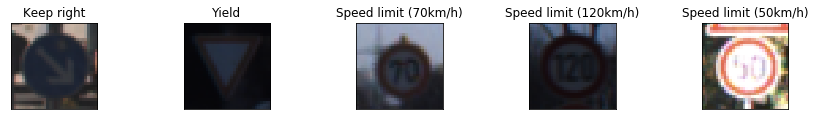

In [17]:
random_train_image_indices = random.sample(range(X_train.shape[0]), 5)
show_images_row(
    X_train_src[random_train_image_indices],
    [trim_label(sign_names[y_train[n]]) for n in random_train_image_indices],
    spacing=0.4
)

#### Augmented data visualization

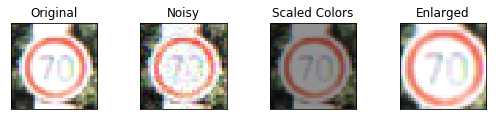

In [18]:
def visualize_augmentation(image_idx):
    TITLES = ["Original", "Noisy", "Scaled Colors", "Enlarged"]
    indices = list(len(X_train_src) * np.array([0, 1, 2, 3]) + image_idx)
    images = [X_train_4[n] for n in indices]
    show_images_row(images, TITLES)

visualize_augmentation(7067)


In [19]:
### Preprocess the data here. It is required to normalize the data. Other preprocessing steps could include 
### converting to grayscale, etc.
### Feel free to use as many code cells as needed.

# Normalize data
X_train = (X_train - 128) / 128
X_train_2 = (X_train_2 - 128) / 128
X_train_3 = (X_train_3 - 128) / 128
X_train_4 = (X_train_4 - 128) / 128
X_train_5 = (X_train_5 - 128) / 128
X_train_6 = (X_train_6 - 128) / 128
X_valid = (X_valid - 128) / 128
X_test = (X_test - 128) / 128

### Model Architecture

In [20]:
### Define your architecture here.
### Feel free to use as many code cells as needed.

In [21]:
# Arguments used for tf.truncated_normal, randomly defines variables for the weights and biases for each layer
INIT_PARAMS = {
    'mu': 0,
    'sigma': 0.1
}

def build_conv_layer(in_var, layer_topology, debug_print_shape):
    mu, sigma = INIT_PARAMS['mu'], INIT_PARAMS['sigma']
    sub_layers = []

    in_depth = layer_topology['in_depth']
    filter_sz = layer_topology['filter_sz']
    out_depth = layer_topology['out_depth']
    stride = layer_topology['stride']
    pool_sz = layer_topology.get('pool_sz')
    
    # Convolutional
    weights = tf.Variable(tf.truncated_normal([filter_sz, filter_sz, in_depth, out_depth],
                                              mean=mu, stddev=sigma))
    bias = tf.Variable(tf.zeros(out_depth))
    c = tf.nn.conv2d(in_var, weights, strides=[1, stride, stride, 1], padding='VALID')
    c = tf.add(c, bias)
    debug_print_shape("convolution", c.get_shape())
    sub_layers.append(("convolution", c))

    # Activation
    a = tf.nn.relu(c)
    debug_print_shape("activateion", a.get_shape())
    sub_layers.append(("activation", a))

    # Pooling
    if pool_sz:
        p = tf.nn.max_pool(a, ksize=[1, pool_sz, pool_sz, 1], strides=[1, pool_sz, pool_sz, 1], padding='VALID')
        debug_print_shape("pooling", p.get_shape())
        sub_layers.append(("pooling", p))
        out_var = p
    else:
        out_var = a
 
    return out_var, sub_layers

def build_fully_connected(in_var, layer_topology, debug_print_shape):
    mu, sigma = INIT_PARAMS['mu'], INIT_PARAMS['sigma']

    input_size = layer_topology['input_size']
    output_size = layer_topology['output_size']
    activation = layer_topology.get('activation', True)
    
    weights = tf.Variable(tf.truncated_normal([input_size, output_size], mean=mu, stddev=sigma))
    bias = tf.Variable(tf.zeros(output_size))
    o = tf.matmul(in_var, weights)
    o = tf.add(o, bias)
    
    debug_print_shape("fully connected", o.get_shape())

    if activation:
        a = tf.nn.relu(o)
        return a
    else:
        return o

def build_dropout(in_var, keep_prob):
    return tf.nn.dropout(in_var, keep_prob)

def build_network(x, topology, debug_print=False):
    def debug_print_shape(layer_description, shape):
        if debug_print:
            print("Layer: {}, shape: {}".format(layer_description, shape))

    in_var = x
    layer_vars = []
    for lr_idx, layer_topology in enumerate(topology):
        layer_type = layer_topology['type']
        
        # Flatten
        if lr_idx > 0 and layer_type == 'fc' and topology[lr_idx - 1]['type'] == 'conv':
            in_var = flatten(in_var)
        
        if layer_type == 'conv':
            out_var, sub_layers = build_conv_layer(in_var, layer_topology, debug_print_shape)
            layer_data = [("Layer {} {}".format(lr_idx + 1, x[0]), x[1]) for x in sub_layers]
            layer_vars.extend(layer_data)
        elif layer_type == 'fc':
            out_var = build_fully_connected(in_var, layer_topology, debug_print_shape)
        elif layer_type == 'dropout':
            out_var = build_dropout(in_var, keep_prob=layer_topology.get('keep_prob', 0.5))
        else:
            raise RuntimeError("Unknown layer type '{}'".format(layer_type))
        
        in_var = out_var
    
    return out_var, layer_vars

In [22]:
def LeNet(x, _, debug_print=False):
    mu, sigma = INIT_PARAMS['mu'], INIT_PARAMS['sigma']
    
    def print_shape(shape):
        if debug_print:
            print(shape)
    
    print_shape(x.get_shape())
        
    # Layer 1: Convolutional. Input = 32x32x3. Output = 28x28x6.
    weights1 = tf.Variable(tf.truncated_normal([5, 5, 3, 6], mean=mu, stddev=sigma))
    bias1 = tf.Variable(tf.zeros(6))
    lr1_convolution = tf.nn.conv2d(x, weights1, strides=[1, 1, 1, 1], padding='VALID')
    lr1_convolution = tf.add(lr1_convolution, bias1)
    print_shape(lr1_convolution.get_shape())

    # Activation.
    lr1_activation = tf.nn.relu(lr1_convolution)
    print_shape(lr1_activation.get_shape())

    # Pooling. Input = 28x28x6. Output = 14x14x6.
    lr1_pooling = tf.nn.max_pool(lr1_activation, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')
    print_shape(lr1_pooling.get_shape())

    # Layer 2: Convolutional. Output = 10x10x16.
    weights2 = tf.Variable(tf.truncated_normal([5, 5, 6, 16], mean=mu, stddev=sigma))
    bias2 = tf.Variable(tf.zeros(16))
    lr2_convolution = tf.nn.conv2d(lr1_pooling, weights2, strides=[1, 1, 1, 1], padding='VALID')
    lr2_convolution = tf.add(lr2_convolution, bias2)
    
    # Activation.
    lr2_activation = tf.nn.relu(lr2_convolution)
    print_shape(lr2_activation.get_shape())

    # Pooling. Input = 10x10x16. Output = 5x5x16.
    lr2_pooling = tf.nn.max_pool(lr2_activation, ksize=[1, 2, 2, 1], strides=[1, 2, 2, 1], padding='VALID')

    # Flatten. Input = 5x5x16. Output = 400.
    print_shape(lr2_pooling.get_shape())
    lr2_flat = flatten(lr2_pooling)
    print_shape(lr2_flat.get_shape())
    
    # Layer 3: Fully Connected. Input = 400. Output = 120.
    weights3 = tf.Variable(tf.truncated_normal([400, 120], mean=mu, stddev=sigma))
    bias3 = tf.Variable(tf.zeros(120))
    lr3 = tf.matmul(lr2_flat, weights3)
    lr3 = tf.add(lr3, bias3)
    
    # Activation.
    lr3 = tf.nn.relu(lr3)
    print_shape(lr3.get_shape())

    # Layer 4: Fully Connected. Input = 120. Output = 84.
    weights4 = tf.Variable(tf.truncated_normal([120, 84], mean=mu, stddev=sigma))
    bias4 = tf.Variable(tf.zeros(84))
    lr4 = tf.matmul(lr3, weights4)
    lr4 = tf.add(lr4, bias4)
    
    # Activation.
    lr4 = tf.nn.relu(lr4)
    print_shape(lr4.get_shape())

    # Layer 5: Fully Connected. Input = 84. Output = n_classes.
    weights5 = tf.Variable(tf.truncated_normal([84, n_classes]))
    bias5 = tf.Variable(tf.zeros(n_classes))
    lr5 = tf.matmul(lr4, weights5)
    lr5 = tf.add(lr5, bias5)
    print_shape(lr5.get_shape())
    
    logits = lr5
    
    layers = [
        ("Layer 1 convolution", lr1_convolution),
        ("Layer 1 activation", lr1_activation),
        ("Layer 1 pooling", lr1_pooling),
        ("Layer 2 convolution", lr2_convolution),
        ("Layer 2 activation", lr2_activation),
        ("Layer 2 pooling", lr2_pooling)
    ]
    
    return logits, layers

### Train, Validate and Test the Model

A validation set can be used to assess how well the model is performing. A low accuracy on the training and validation
sets imply underfitting. A high accuracy on the training set but low accuracy on the validation set implies overfitting.

In [23]:
### Train your model here.
### Calculate and report the accuracy on the training and validation set.
### Once a final model architecture is selected, 
### the accuracy on the test set should be calculated and reported as well.
### Feel free to use as many code cells as needed.

In [24]:
### Training pipeline
DEFAULT_N_EPOCHS = 10
DEFAULT_BATCH_SIZE = 128
DEFAULT_LEARNING_RATE = 0.001

def build_training(symbol, labels, rate=DEFAULT_LEARNING_RATE):
    cross_entropy = tf.nn.softmax_cross_entropy_with_logits(labels=labels, logits=symbol)
    loss_operation = tf.reduce_mean(cross_entropy)
    optimizer = tf.train.AdamOptimizer(learning_rate=rate)
    training_operation = optimizer.minimize(loss_operation)
    
    return training_operation

In [25]:
#### Evaluation pipeline
def build_evaluation(symbol, labels, batch_size=DEFAULT_BATCH_SIZE):
    correct_prediction = tf.equal(tf.argmax(symbol, 1), tf.argmax(labels, 1))
    accuracy_operation = tf.reduce_mean(tf.cast(correct_prediction, tf.float32))

    def evaluate(x, y, X_data, y_data):
        num_examples = len(X_data)
        total_accuracy = 0
        sess = tf.get_default_session()
        for offset in range(0, num_examples, batch_size):
            batch_x = X_data[offset:offset+batch_size]
            batch_y = y_data[offset:offset+batch_size]
            accuracy = sess.run(accuracy_operation, feed_dict={x: batch_x, y: batch_y})
            total_accuracy += (accuracy * len(batch_x))
        return total_accuracy / num_examples
    
    return evaluate

In [26]:
def train(dataset, x, y, training_operation, evaluate,
          epochs=DEFAULT_N_EPOCHS, model_file=None, sampling_rate=None,
          batch_size=DEFAULT_BATCH_SIZE):
    saver = tf.train.Saver()
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        
        X_in, y_in = dataset['X'], dataset['y']

        sampling_rate = sampling_rate or 1
        sample_indices = np.random.randint(
            X_in.shape[0], size=int(X_in.shape[0] / (sampling_rate * 10)))
        X_sample = X_in[sample_indices]
        y_sample = y_in[sample_indices]
        train_accuracy = []
        validation_accuracy = []
        
        sys.stdout.write("Training")
        sys.stdout.flush()
        for i in range(epochs):
            X_shuffled, y_shuffled = shuffle(X_in, y_in)
            
            n_samples = int(X_in.shape[0] / sampling_rate)
            X_shuffled, y_shuffled = X_shuffled[:n_samples], y_shuffled[:n_samples]

            for offset in range(0, n_samples, batch_size):
                end = offset + batch_size
                batch_x, batch_y = X_shuffled[offset:end], y_shuffled[offset:end]
                sess.run(training_operation, feed_dict={x: batch_x, y: batch_y})

            # To increase training speed, compute training accuracy
            # on a sample of training data set
            train_accuracy.append(evaluate(x, y, X_sample, y_sample))
            validation_accuracy.append(evaluate(x, y, X_valid, y_valid))
            sys.stdout.write(".")
            sys.stdout.flush()
        print("done.")

        if model_file:
            saver.save(sess, model_file)
            print("Model saved")

        return train_accuracy, validation_accuracy

def plot_accuracy(train_accuracy, validation_accuracy):
    # Visualize accuracy
    plt.plot(train_accuracy, label='train')
    plt.plot(validation_accuracy, label='validation')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

def visualize_validation_accuracy(experiments):
    for experiment in experiments:
        pth = get_accuracy_path(experiment)
        
        # Load accuracy data
        with open(pth, 'rb') as f:
            pickle.load(f)  # Skip training accuracy
            acc = pickle.load(f)
            
        # Visualize accuracy
        plt.plot(acc, label=experiment["id"])

    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend()
    plt.show()

In [27]:
# Input = 32x32x3

LENET_TOPOLOGY = [
    {'type': 'conv', 'in_depth': 3, 'filter_sz': 5, 'out_depth': 6, 'stride': 1, 'pool_sz': 2},  # 28x28x6 -> 14x14x6
    {'type': 'conv', 'in_depth': 6, 'filter_sz': 5, 'out_depth': 16, 'stride': 1, 'pool_sz': 2},  # 10x10x16 -> 5x5x16
    {'type': 'fc', 'input_size': 400, 'output_size': 120},
    {'type': 'fc', 'input_size': 120,'output_size': 84},
    {'type': 'fc', 'input_size': 84, 'output_size': n_classes, 'activation': False}
]

NETWORK1 = [
    {'type': 'conv', 'in_depth': 3, 'filter_sz': 3, 'out_depth': 9, 'stride': 1, 'pool_sz': 2},  # 30x30x9 -> 15x15x9
    {'type': 'conv', 'in_depth': 9, 'filter_sz': 4, 'out_depth': 20, 'stride': 1},  # 12x12x20
    {'type': 'conv', 'in_depth': 20, 'filter_sz': 4, 'out_depth': 40, 'stride': 1, 'pool_sz': 2},  # 8x8x40 -> 4x4x40
    {'type': 'fc', 'input_size': 640, 'output_size': 260},
    {'type': 'fc', 'input_size': 260, 'output_size': 130},
    {'type': 'fc', 'input_size': 130, 'output_size': n_classes, 'activation': False}
]

NETWORK2 = [
    {'type': 'conv', 'in_depth': 3, 'filter_sz': 5, 'out_depth': 6, 'stride': 1, 'pool_sz': 2},  # 28x28x6 -> 14x14x6
    {'type': 'conv', 'in_depth': 6, 'filter_sz': 5, 'out_depth': 16, 'stride': 1, 'pool_sz': 2},  # 10x10x16 -> 5x5x16
    {'type': 'fc', 'input_size': 400, 'output_size': 300},
    {'type': 'fc', 'input_size': 300, 'output_size': 200},
    {'type': 'fc', 'input_size': 200, 'output_size': 120},
    {'type': 'fc', 'input_size': 120, 'output_size': n_classes, 'activation': False}
]

NETWORK3 = [
    {'type': 'conv', 'in_depth': 3, 'filter_sz': 3, 'out_depth': 9, 'stride': 1, 'pool_sz': 2},  # 30x30x9 -> 15x15x9
    {'type': 'conv', 'in_depth': 9, 'filter_sz': 4, 'out_depth': 20, 'stride': 1},  # 12x12x20
    {'type': 'conv', 'in_depth': 20, 'filter_sz': 4, 'out_depth': 40, 'stride': 1, 'pool_sz': 2},  # 8x8x40 -> 4x4x40
    {'type': 'fc', 'input_size': 640, 'output_size': 400},
    {'type': 'fc', 'input_size': 400, 'output_size': 200},
    {'type': 'fc', 'input_size': 200,'output_size': 100},
    {'type': 'fc', 'input_size': 100, 'output_size': n_classes, 'activation': False}
]

NETWORK4 = [
    {'type': 'conv', 'in_depth': 3, 'filter_sz': 3, 'out_depth': 9, 'stride': 1, 'pool_sz': 2},  # 30x30x9 -> 15x15x9
    {'type': 'dropout'},
    {'type': 'conv', 'in_depth': 9, 'filter_sz': 4, 'out_depth': 20, 'stride': 1},  # 12x12x20
    {'type': 'conv', 'in_depth': 20, 'filter_sz': 4, 'out_depth': 40, 'stride': 1, 'pool_sz': 2},  # 8x8x40 -> 4x4x40
    {'type': 'fc', 'input_size': 640, 'output_size': 260},
    {'type': 'fc', 'input_size': 260, 'output_size': 130},
    {'type': 'fc', 'input_size': 130, 'output_size': n_classes, 'activation': False}
]

NETWORK5 = [
    {'type': 'conv', 'in_depth': 3, 'filter_sz': 3, 'out_depth': 9, 'stride': 1, 'pool_sz': 2},  # 30x30x9 -> 15x15x9
    {'type': 'dropout', 'keep_prob': 0.75},
    {'type': 'conv', 'in_depth': 9, 'filter_sz': 4, 'out_depth': 20, 'stride': 1},  # 12x12x20
    {'type': 'conv', 'in_depth': 20, 'filter_sz': 4, 'out_depth': 40, 'stride': 1, 'pool_sz': 2},  # 8x8x40 -> 4x4x40
    {'type': 'fc', 'input_size': 640, 'output_size': 260},
    {'type': 'fc', 'input_size': 260, 'output_size': 130},
    {'type': 'fc', 'input_size': 130, 'output_size': n_classes, 'activation': False}
]

In [28]:
EXPERIMENTS_DIR = 'experiments'
if not os.path.exists(EXPERIMENTS_DIR):
    os.mkdir(EXPERIMENTS_DIR)

def run_experiment(experiment, model_file):
    dataset = experiment.get("dataset", {'X': X_train, 'y': y_train})
    network_builder = experiment["network_builder"]
    batch_size = experiment.get("batch_size", DEFAULT_BATCH_SIZE)
    learning_rate = experiment.get("learning_rate", DEFAULT_LEARNING_RATE)
    
    tf.reset_default_graph()

    x = tf.placeholder(tf.float32, (None, 32, 32, 3))
    y = tf.placeholder(tf.int32, (None))
    one_hot_y = tf.one_hot(y, n_classes)
    
    network = network_builder(x, experiment["topology"])[0]
    
    training = build_training(network, one_hot_y, learning_rate)
    evaluate = build_evaluation(network, one_hot_y, batch_size)

    return train(
        dataset,
        x, y,
        training,
        evaluate,
        epochs=experiment.get('epochs', DEFAULT_N_EPOCHS),
        model_file=model_file,
        sampling_rate=experiment.get('sampling_rate', 1),
        batch_size=batch_size
    )

def get_experiment_dir(experiment):
    experiment_dir = os.path.join(EXPERIMENTS_DIR, experiment["id"])
    if not os.path.exists(experiment_dir):
        os.mkdir(experiment_dir)
    return experiment_dir

def get_accuracy_path(experiment):
    return os.path.join(get_experiment_dir(experiment), "accuracy.p")

def get_model_path(experiment):
    return os.path.join(get_experiment_dir(experiment), "model")

def run_experiments(experiments):
    for idx, experiment in enumerate(experiments):
        print("Running experiment {} of {}: {}".format(
            idx + 1, len(experiments), experiment['description']))
        
        experiment_dir = os.path.join(EXPERIMENTS_DIR, experiment["id"])
        if not os.path.exists(experiment_dir):
            os.mkdir(experiment_dir)
        accuracy_path = get_accuracy_path(experiment)

        try:
            # Try load accuracy data from disk
            with open(accuracy_path, 'rb') as f:
                train_accuracy = pickle.load(f)
                validation_accuracy = pickle.load(f)
                print("Experiment results loaded from disk.")
        except Exception:
            # Run training
            model_file = get_model_path(experiment)
            train_accuracy, validation_accuracy = run_experiment(experiment, model_file)
            
            # Save accuracy data
            with open(accuracy_path, 'wb') as f:
                pickle.dump(train_accuracy, f)
                pickle.dump(validation_accuracy, f)

        print("Training accuracy = {:.3f}, validation accuracy = {:.3f}"
              .format(train_accuracy[-1], validation_accuracy[-1]))
        plot_accuracy(train_accuracy, validation_accuracy)

#### Trying LeNet architecture

In [29]:
EXPERIMENTS1 = [
    {
        'id': 'lenet',
        'description': 'LeNet',
        'network_builder': LeNet,
        'topology': None,
        'epochs': 20,
    },
    {
        'id': 'lenet_dynamic',
        'description': 'Dynamically built LeNet',
        'network_builder': build_network,
        'topology': LENET_TOPOLOGY,
        'epochs': 20,
    },
]

Running experiment 1 of 2: LeNet
Experiment results loaded from disk.
Training accuracy = 0.995, validation accuracy = 0.914


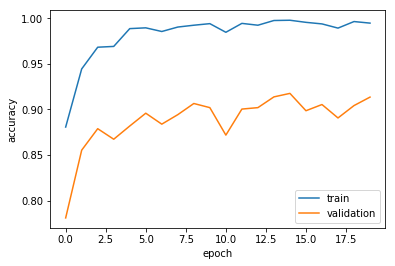

Running experiment 2 of 2: Dynamically built LeNet
Experiment results loaded from disk.
Training accuracy = 0.996, validation accuracy = 0.910


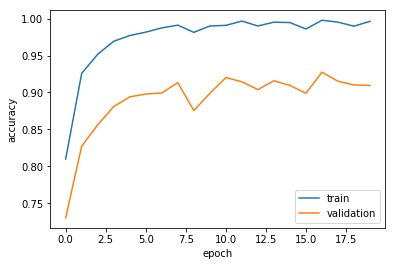

In [30]:
run_experiments(EXPERIMENTS1)

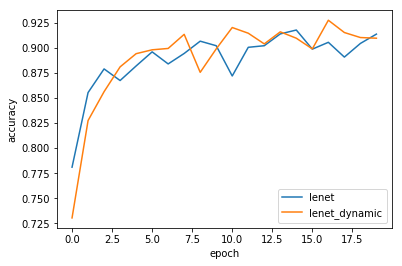

In [31]:
visualize_validation_accuracy(EXPERIMENTS1)

#### Trying different network architectures

In [32]:
EXPERIMENTS2 = [
    {
        'id': 'more_conv_layers',
        'description': 'More convolutional layers',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
    },
    {
        'id': 'more_dense_layers',
        'description': 'More dense layers',
        'network_builder': build_network,
        'topology': NETWORK2,
        'epochs': 40,
    },
    {
        'id': 'larger_network',
        'description': 'Larger network',
        'network_builder': build_network,
        'topology': NETWORK3,
        'epochs': 40,
    },
]

Running experiment 1 of 3: More convolutional layers
Experiment results loaded from disk.
Training accuracy = 1.000, validation accuracy = 0.974


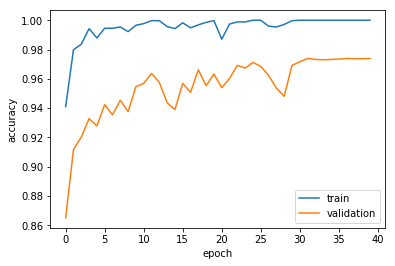

Running experiment 2 of 3: More dense layers
Experiment results loaded from disk.
Training accuracy = 1.000, validation accuracy = 0.951


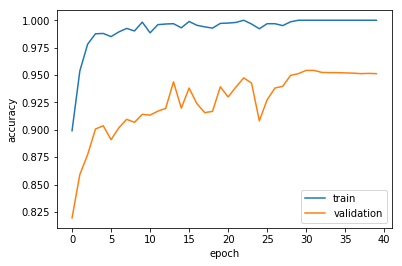

Running experiment 3 of 3: Larger network
Experiment results loaded from disk.
Training accuracy = 0.997, validation accuracy = 0.956


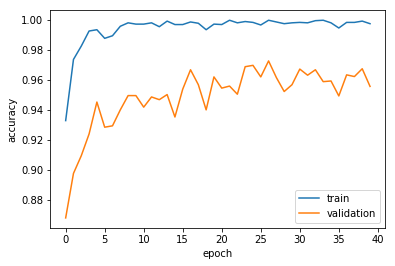

In [33]:
run_experiments(EXPERIMENTS2)

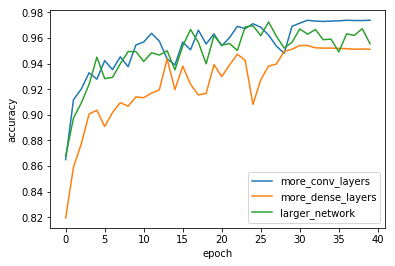

In [34]:
visualize_validation_accuracy(EXPERIMENTS2)

#### Trying different batch size

In [35]:
EXPERIMENTS3 = [
    {
        'id': 'batch_size_10',
        'description': 'Batch size 10',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
        'batch_size': 10,
    },
    {
        'id': 'batch_size_30',
        'description': 'Batch size 30',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
        'batch_size': 30,
    },
    {
        'id': 'batch_size_300',
        'description': 'Batch size 300',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
        'batch_size': 300,
    },
    {
        'id': 'batch_size_1000',
        'description': 'Batch size 1000',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
        'batch_size': 1000,
    },
]

Running experiment 1 of 4: Batch size 10
Experiment results loaded from disk.
Training accuracy = 0.992, validation accuracy = 0.949


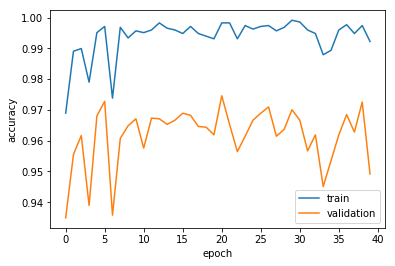

Running experiment 2 of 4: Batch size 30
Experiment results loaded from disk.
Training accuracy = 0.999, validation accuracy = 0.969


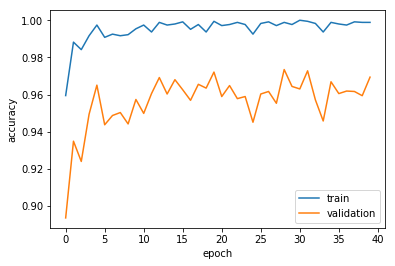

Running experiment 3 of 4: Batch size 300
Experiment results loaded from disk.
Training accuracy = 1.000, validation accuracy = 0.957


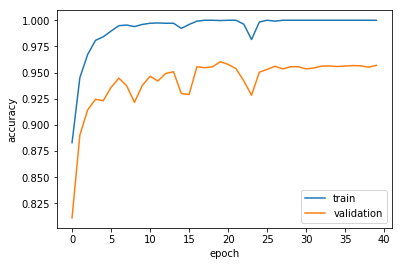

Running experiment 4 of 4: Batch size 1000
Experiment results loaded from disk.
Training accuracy = 0.999, validation accuracy = 0.926


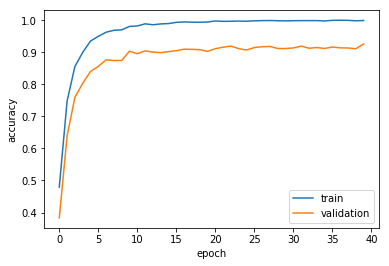

In [36]:
run_experiments(EXPERIMENTS3)

Default batch size is 128


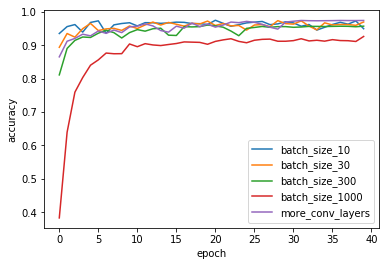

In [37]:
print("Default batch size is {}".format(DEFAULT_BATCH_SIZE))
visualize_validation_accuracy(chain(EXPERIMENTS3, [EXPERIMENTS2[0]]))

#### Trying different learning rate

In [38]:
EXPERIMENTS4 = [
    {
        'id': 'learning_rate_0.01',
        'description': 'Learning rate 0.01',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
        'learning_rate': 0.01,
    },
    {
        'id': 'learning_rate_0.003',
        'description': 'Learning rate 0.003',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
        'learning_rate': 0.003,
    },
    {
        'id': 'learning_rate_0.0003',
        'description': 'Learning rate 0.0003',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
        'learning_rate': 0.0003,
    },
    {
        'id': 'learning_rate_0.0001',
        'description': 'Batch size 0.0001',
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
        'learning_rate': 0.0001,
    },
]

Running experiment 1 of 4: Learning rate 0.01
Experiment results loaded from disk.
Training accuracy = 0.961, validation accuracy = 0.916


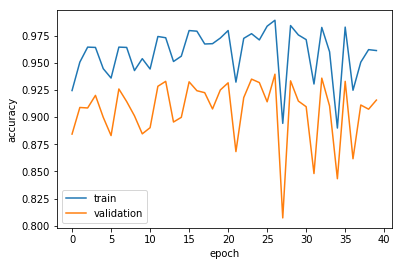

Running experiment 2 of 4: Learning rate 0.003
Experiment results loaded from disk.
Training accuracy = 0.993, validation accuracy = 0.963


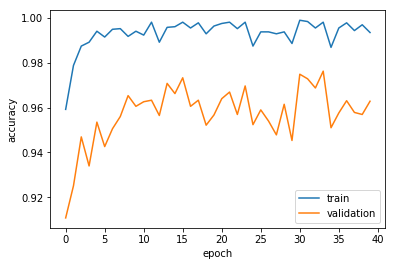

Running experiment 3 of 4: Learning rate 0.0003
Experiment results loaded from disk.
Training accuracy = 1.000, validation accuracy = 0.938


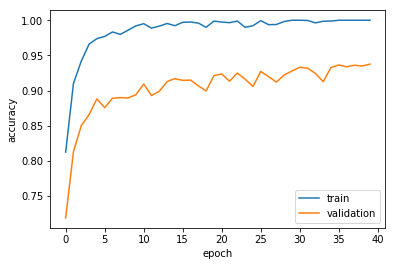

Running experiment 4 of 4: Batch size 0.0001
Experiment results loaded from disk.
Training accuracy = 1.000, validation accuracy = 0.909


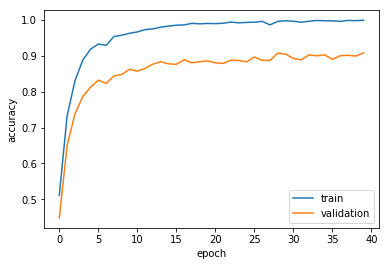

In [39]:
run_experiments(EXPERIMENTS4)

Default learning rate is 0.001


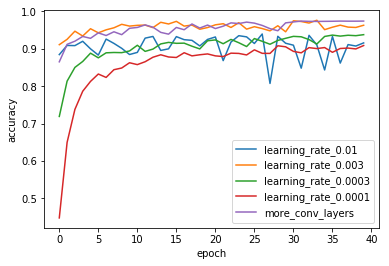

In [40]:
print("Default learning rate is {}".format(DEFAULT_LEARNING_RATE))
visualize_validation_accuracy(chain(EXPERIMENTS4, [EXPERIMENTS2[0]]))

#### Trying different data sets

In [41]:
EXPERIMENTS5 = [
    {
        'id': 'dataset_2',
        'description': 'Data set 2 (noise)',
        'dataset': {'X': X_train_2, 'y': y_train_2},
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
    },
    {
        'id': 'dataset_3',
        'description': 'Data set 3 (noise + colors)',
        'dataset': {'X': X_train_3, 'y': y_train_3},
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40
    },
    {
        'id': 'dataset_4',
        'description': 'Data set 4 (noise + colors + zoom)',
        'dataset': {'X': X_train_4, 'y': y_train_4},
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
    },
    {
        'id': 'dataset_5',
        'description': 'Data set 5 (noise + zoom)',
        'dataset': {'X': X_train_5, 'y': y_train_5},
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40,
    },
    {
        'id': 'dataset_6',
        'description': 'Data set 6 (noise + zoom + reduced number of samples)',
        'dataset': {'X': X_train_6, 'y': y_train_6},
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 40
    },
]

Running experiment 1 of 5: Data set 2 (noise)
Experiment results loaded from disk.
Training accuracy = 0.999, validation accuracy = 0.962


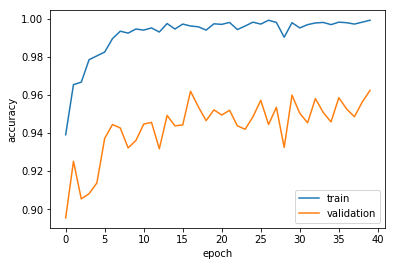

Running experiment 2 of 5: Data set 3 (noise + colors)
Experiment results loaded from disk.
Training accuracy = 0.999, validation accuracy = 0.960


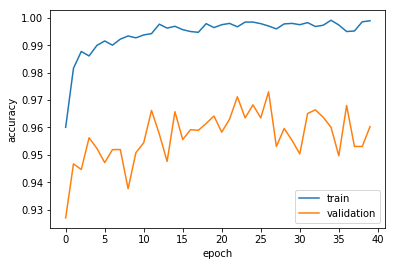

Running experiment 3 of 5: Data set 4 (noise + colors + zoom)
Experiment results loaded from disk.
Training accuracy = 0.998, validation accuracy = 0.963


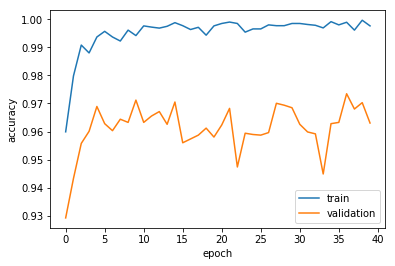

Running experiment 4 of 5: Data set 5 (noise + zoom)
Experiment results loaded from disk.
Training accuracy = 0.996, validation accuracy = 0.964


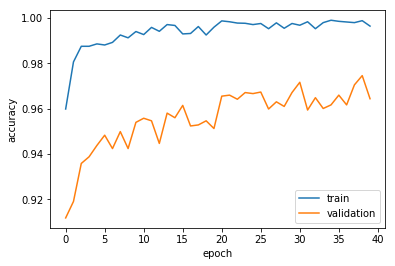

Running experiment 5 of 5: Data set 6 (noise + zoom + reduced number of samples)
Experiment results loaded from disk.
Training accuracy = 0.996, validation accuracy = 0.958


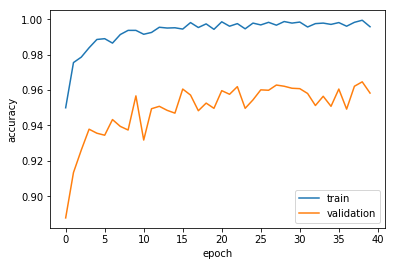

In [42]:
run_experiments(EXPERIMENTS5)

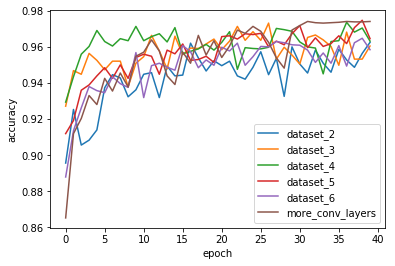

In [43]:
visualize_validation_accuracy(chain(EXPERIMENTS5, [EXPERIMENTS2[0]]))

#### Repeating experiment 5 with 60 epochs and learning rate 0.0009

In [44]:
EXPERIMENTS5_60 = [
    {
        'id': 'dataset_4_60',
        'description': 'Data set 4 (noise + colors + zoom)',
        'dataset': {'X': X_train_4, 'y': y_train_4},
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 60,
        'learning_rate': 0.0009,
    },
    {
        'id': 'dataset_5_60',
        'description': 'Data set 5 (noise + zoom)',
        'dataset': {'X': X_train_5, 'y': y_train_5},
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 60,
        'learning_rate': 0.0009,
    },
    {
        'id': 'dataset_6_60',
        'description': 'Data set 6 (noise + zoom + reduced number of samples)',
        'dataset': {'X': X_train_6, 'y': y_train_6},
        'network_builder': build_network,
        'topology': NETWORK1,
        'epochs': 60,
        'learning_rate': 0.0009,
    },
]

Running experiment 1 of 3: Data set 4 (noise + colors + zoom)
Experiment results loaded from disk.
Training accuracy = 0.999, validation accuracy = 0.964


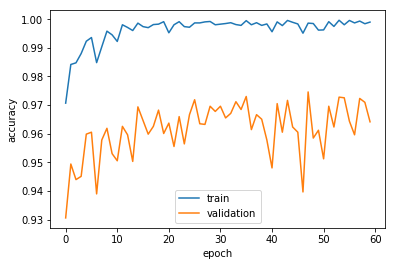

Running experiment 2 of 3: Data set 5 (noise + zoom)
Experiment results loaded from disk.
Training accuracy = 0.998, validation accuracy = 0.961


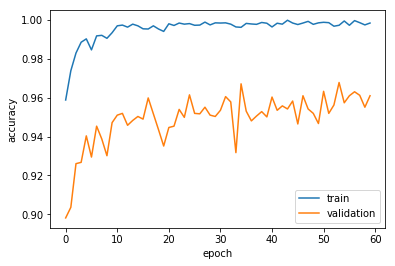

Running experiment 3 of 3: Data set 6 (noise + zoom + reduced number of samples)
Experiment results loaded from disk.
Training accuracy = 1.000, validation accuracy = 0.947


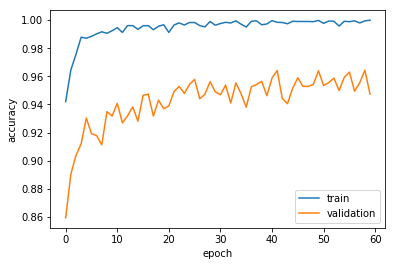

In [45]:
run_experiments(EXPERIMENTS5_60)

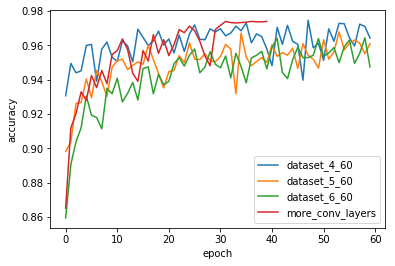

In [46]:
visualize_validation_accuracy(chain(EXPERIMENTS5_60, [EXPERIMENTS2[0]]))

#### Repeating experiment 5 on NETWORK3

In [47]:
EXPERIMENTS5_NET3 = [
    {
        'id': 'dataset_2_net3',
        'description': 'Data set 2 (noise)',
        'dataset': {'X': X_train_2, 'y': y_train_2},
        'network_builder': build_network,
        'topology': NETWORK3,
        'epochs': 40,
    },
    {
        'id': 'dataset_3_net3',
        'description': 'Data set 3 (noise + colors)',
        'dataset': {'X': X_train_3, 'y': y_train_3},
        'network_builder': build_network,
        'topology': NETWORK3,
        'epochs': 40
    },
    {
        'id': 'dataset_4_net3',
        'description': 'Data set 4 (noise + colors + zoom)',
        'dataset': {'X': X_train_4, 'y': y_train_4},
        'network_builder': build_network,
        'topology': NETWORK3,
        'epochs': 40,
    },
    {
        'id': 'dataset_5_net3',
        'description': 'Data set 5 (noise + zoom)',
        'dataset': {'X': X_train_5, 'y': y_train_5},
        'network_builder': build_network,
        'topology': NETWORK3,
        'epochs': 40,
    },
    {
        'id': 'dataset_6_net3',
        'description': 'Data set 6 (noise + zoom + reduced number of samples)',
        'dataset': {'X': X_train_6, 'y': y_train_6},
        'network_builder': build_network,
        'topology': NETWORK3,
        'epochs': 40,
    },
]

Running experiment 1 of 5: Data set 2 (noise)
Experiment results loaded from disk.
Training accuracy = 1.000, validation accuracy = 0.955


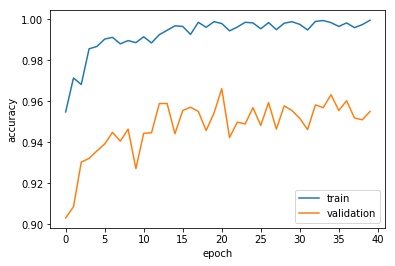

Running experiment 2 of 5: Data set 3 (noise + colors)
Experiment results loaded from disk.
Training accuracy = 0.999, validation accuracy = 0.972


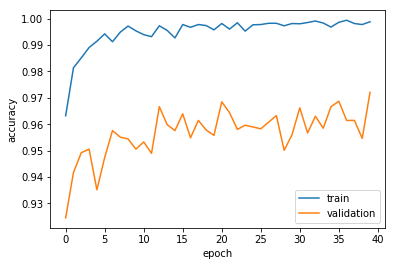

Running experiment 3 of 5: Data set 4 (noise + colors + zoom)
Experiment results loaded from disk.
Training accuracy = 0.998, validation accuracy = 0.961


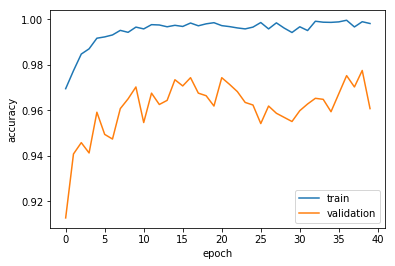

Running experiment 4 of 5: Data set 5 (noise + zoom)
Experiment results loaded from disk.
Training accuracy = 1.000, validation accuracy = 0.958


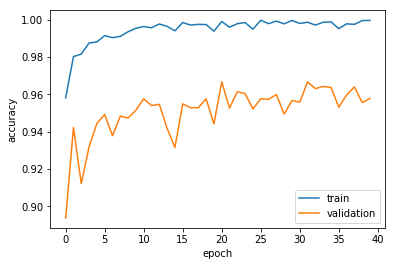

Running experiment 5 of 5: Data set 6 (noise + zoom + reduced number of samples)
Experiment results loaded from disk.
Training accuracy = 0.998, validation accuracy = 0.966


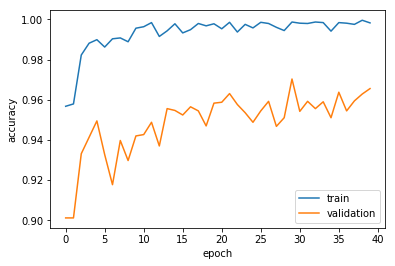

In [48]:
run_experiments(EXPERIMENTS5_NET3)

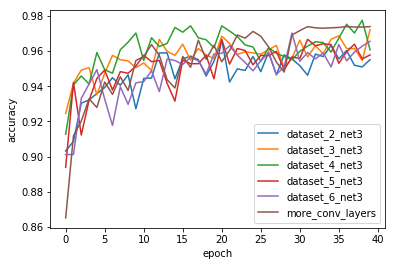

In [49]:
visualize_validation_accuracy(chain(EXPERIMENTS5_NET3, [EXPERIMENTS2[0]]))

#### Tryting dropout

In [50]:
EXPERIMENTS6 = [
    {
        'id': 'one_dropout_prob_0.5',
        'description': 'One dropout layer, keep_prob=0.5',
        'network_builder': build_network,
        'topology': NETWORK4,
        'epochs': 40,
    },
    {
        'id': 'one_dropout_prob_0.75',
        'description': 'One dropout layer, keep_prob=0.75',
        'network_builder': build_network,
        'topology': NETWORK5,
        'epochs': 40,
    },
]

Running experiment 1 of 2: One dropout layer, keep_prob=0.5
Experiment results loaded from disk.
Training accuracy = 0.991, validation accuracy = 0.922


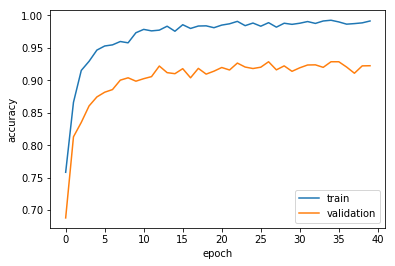

Running experiment 2 of 2: One dropout layer, keep_prob=0.75
Experiment results loaded from disk.
Training accuracy = 0.989, validation accuracy = 0.920


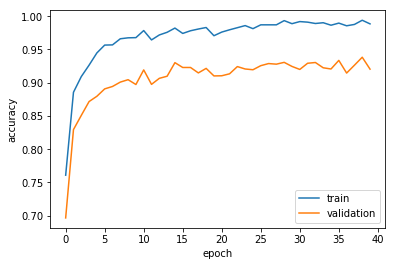

In [51]:
run_experiments(EXPERIMENTS6)

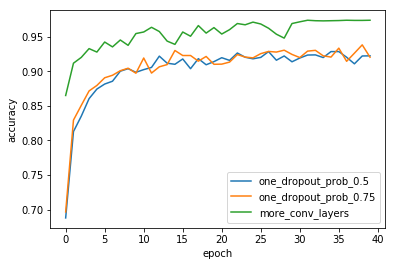

In [52]:
visualize_validation_accuracy(chain(EXPERIMENTS6, [EXPERIMENTS2[0]]))

#### Auxiliary classification functions

In [53]:
def build_classification_network(experiment):
    tf.reset_default_graph()

    network_builder = experiment["network_builder"]
    x = tf.placeholder(tf.float32, (None, 32, 32, 3))
    network, layers = network_builder(x, experiment["topology"])

    return network, x, layers

def load_model(experiment, sess):
    sess.run(tf.global_variables_initializer())
    meta_path = os.path.join(get_experiment_dir(experiment), "model.meta")
    model_path = get_model_path(experiment)
    saver = tf.train.Saver()
    saver.restore(sess, model_path)

In [54]:
# Classify signs

SELECTED_EXPERIMENT = EXPERIMENTS2[0]

def classify(signs):
    network, x, _ = build_classification_network(SELECTED_EXPERIMENT)

    with tf.Session() as sess:
        load_model(SELECTED_EXPERIMENT, sess)
        labels = sess.run(network, feed_dict={x: signs})
        return [{"label": l.argmax(), "probabilities": l} for l in labels]

def get_top_probabilities(probabilities, n=5, prec=2):
    annotated = list(enumerate(probabilities))
    annotated.sort(key=itemgetter(1), reverse=True)
    format_str = "{{:.{}f}}".format(prec)
    result = [(sign_names[idx], format_str.format(val)) for idx, val in annotated[:n]]
    return result

### Check network performance on a test dataset

Evenutally, after having picked network architecture and dataset, we can run evaluation on the test dataset.

In [55]:
def get_accuracy_metrics(dataset, labels):
    predictions = classify(dataset)
    predicted_labels = np.array([x['label'] for x in predictions])
    
    accuracy = accuracy_score(labels, predicted_labels)
    precision = precision_score(labels, predicted_labels, average=None)
    recall = recall_score(labels, predicted_labels, average=None)
    f1 = f1_score(labels, predicted_labels, average=None)
    
    return accuracy, precision, recall, f1

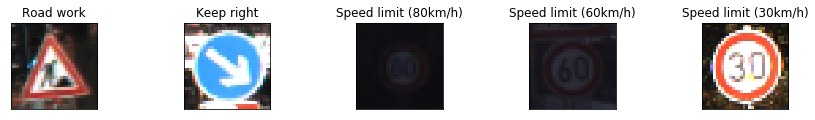

INFO:tensorflow:Restoring parameters from experiments/more_conv_layers/model

Classification accuracy for the test data set is 0.959



Class,Number of samples,Precision,Recall,F1 score
Speed limit (50km/h),2010,0.963,0.977,0.970
Speed limit (30km/h),1980,0.909,0.990,0.948
Yield,1920,0.993,0.996,0.994
Priority road,1890,0.986,0.945,0.965
Keep right,1860,0.987,0.990,0.988
No passing for vehicles over 3.5 metric tons,1800,0.994,0.994,0.994
Speed limit (70km/h),1770,0.980,0.967,0.973
Speed limit (80km/h),1650,0.967,0.940,0.953
Road work,1350,0.947,0.977,0.962
No passing,1320,0.966,0.998,0.982


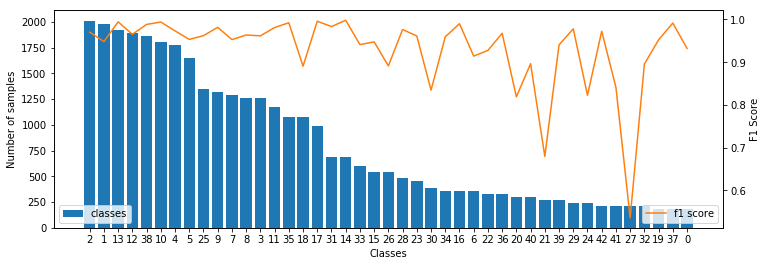

In [56]:
def visualize_test_metrics(sorted_indices, n_samples, f1):
    # Visualize accuracy
    class_range = range(n_classes)
    
    fig = plt.figure(figsize=(12, 4))
    ax1 = fig.add_subplot(111)
    ax1.bar(class_range, n_samples, label="classes")
    ax1.set_ylabel("Number of samples")
    ax1.set_xlabel('Classes')
    ax1.legend(loc=3)

    ax2 = ax1.twinx()
    ax2.plot(f1, 'C1', label="f1 score")
    ax2.set_ylabel('F1 Score')
    ax2.legend(loc=4)
    
    plt.xticks(class_range, sorted_indices)
    plt.show()

def show_test_metrics():
    class_size = count_samples(y_train_src)
    # Sort
    sorted_indices = np.flip(class_size.argsort(), axis=0)

    accuracy, precision, recall, f1 = get_accuracy_metrics(X_test, y_test)

    print("\nClassification accuracy for the test data set is {:.3f}\n".format(accuracy))

    data = []
    for n in sorted_indices:
        data.append((
            sign_names[n],
            int(class_size[n]),
            "{:.3f}".format(precision[n]),
            "{:.3f}".format(recall[n]),
            "{:.3f}".format(f1[n])
        ))
    
    header = [
        "Class",
        "Number of samples",
        "Precision",
        "Recall",
        "F1 score"
    ]
    
    display_table(data, header)
    visualize_test_metrics(
        sorted_indices,
        np.array(class_size)[sorted_indices],
        f1[sorted_indices]
    )

random_test_image_indices = random.sample(range(X_test.shape[0]), 5)
show_images_row(
    X_test_visualization[random_test_image_indices],
    [trim_label(sign_names[y_test[n]]) for n in random_test_image_indices],
    spacing=0.4
)
show_test_metrics()

---

## Step 3: Test a Model on New Images

To give yourself more insight into how your model is working, download at least five pictures of German traffic signs from the web and use your model to predict the traffic sign type.

You may find `signnames.csv` useful as it contains mappings from the class id (integer) to the actual sign name.

### Load and Output the Images

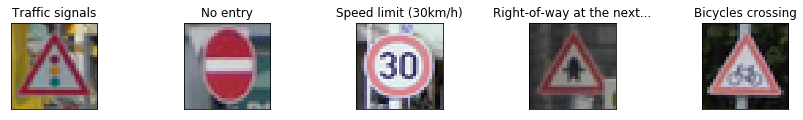

In [57]:
### Load the images and plot them here.
### Feel free to use as many code cells as needed.

FOLDER_NAME = 'map_data'
STREET_VIEW_IMAGES = [
    ['Stuttgart.png', [
        {'x': 775, 'y': 376, 'size': 47, 'label': 26}
    ]],
    
    ['Munich.png', [
        {'x': 654, 'y': 581, 'size': 32, 'label': 38}
    ]],
    
    ['Hannover.png', [
        {'x': 890, 'y': 396, 'size': 66, 'label': 1},
    ]],
    
    ['Berlin.png', [
        {'x': 1033, 'y': 190, 'size': 109, 'label': 11},
        {'x': 1040, 'y': 387, 'size': 79, 'label': 37}
    ]],
    
    ['Duisburg-2.png', [
        {'x': 540, 'y': 174, 'size': 206, 'label': 28},
        {'x': 1615, 'y': 177, 'size': 169, 'label': 1},
    ]],

    ['Duisburg-3.png', [
        {'x': 1311, 'y': 317, 'size': 187, 'label': 17},
    ]],

    ['Duisburg-4.png', [
        {'x': 1244, 'y': 108, 'size': 220, 'label': 22},
    ]],

    ['Duisburg-5.png', [
        {'x': 264, 'y': 151, 'size': 132, 'label': 35},
        {'x': 240, 'y': 251, 'size': 179, 'label': 13},
    ]],

    ['Duisburg-6.png', [
        {'x': 1170, 'y': 87, 'size': 178, 'label': 36},
        {'x': 1145, 'y': 232, 'size': 232, 'label': 13},
    ]],

    ['Duisburg-7.png', [
        {'x': 382, 'y': 336, 'size': 73, 'label': 38},
    ]],

    ['Duisburg-8.png', [
        {'x': 1064, 'y': 311, 'size': 91, 'label': 29},
    ]],

    ['Duisburg-9.png', [
        {'x': 187, 'y': 355, 'size': 79, 'label': 15},
    ]],

    ['Duisburg-10.png', [
        {'x': 597, 'y': 441, 'size': 100, 'label': 17},
        {'x': 687, 'y': 445, 'size': 94, 'label': 38},
    ]],

    ['Duisburg-11.png', [
        {'x': 100, 'y': 110, 'size': 147, 'label': 34},
        {'x': 711, 'y': 526, 'size': 74, 'label': 38},
        {'x': 893, 'y': 377, 'size': 51, 'label': 1},
    ]],

    ['Duisburg-12.png', [
        {'x': 219, 'y': 386, 'size': 97, 'label': 1},
        {'x': 1388, 'y': 394, 'size': 83, 'label': 1},
    ]],
    
    ['Duisburg-13.png', [
        {'x': 1196, 'y': 741, 'size': 47, 'label': 13},
    ]],

    ['Duisburg-14.png', [
        {'x': 1070, 'y': 200, 'size': 131, 'label': 11},
    ]],

    ['Duisburg-16.png', [
        {'x': 78, 'y': 317, 'size': 179, 'label': 37},
        {'x': 1887, 'y': 282, 'size': 120, 'label': 35},
        {'x': 1886, 'y': 413, 'size': 109, 'label': 12},
    ]],

    ['Duisburg-17.png', [
        {'x': 69, 'y': 386, 'size': 138, 'label': 36},
        {'x': 947, 'y': 93, 'size': 32, 'label': 36},
    ]],

    ['Duisburg-18.png', [
        {'x': 106, 'y': 121, 'size': 143, 'label': 18},
    ]],

    ['Duisburg-19.png', [
        {'x': 315, 'y': 339, 'size': 129, 'label': 14},
        {'x': 1297, 'y': 358, 'size': 119, 'label': 14},
        {'x': 339, 'y': 284, 'size': 83, 'label': 34},
        {'x': 1760, 'y': 474, 'size': 91, 'label': 13},
    ]],

    ['Duisburg-20.png', [
        {'x': 1114, 'y': 162, 'size': 84, 'label': 18},
    ]],

    ['Duisburg-21.png', [
        {'x': 425, 'y': 150, 'size': 116, 'label': 25},
    ]],

    ['Duisburg-23.png', [
        {'x': 1010, 'y': 400, 'size': 72, 'label': 11},
    ]],
    
    ['Duisburg-24.png', [
        {'x': 976, 'y': 296, 'size': 184, 'label': 1},
    ]],
]

# "Zoom out" when extracting a sign image from a street image
# Setting this value to a non-zero makes signs appear smaller
EXPAND_BY = 0  # Pixels

german_sign_images = []
german_sign_labels = []
german_sign_notes = []

for image_name, signs in STREET_VIEW_IMAGES:
    for idx, sign_params in enumerate(signs):
        image_file_path = os.path.join(FOLDER_NAME, image_name)
        im = Image.open(image_file_path)

        sign_pos_x = sign_params['x'] - EXPAND_BY
        sign_pos_y = sign_params['y'] - EXPAND_BY
        sign_square_size = sign_params['size'] + EXPAND_BY * 2

        im = im.crop((
            sign_pos_x, sign_pos_y, sign_pos_x+sign_square_size, sign_pos_y+sign_square_size
        ))
        im.thumbnail((32, 32), Image.ANTIALIAS)
        
        german_sign_images.append(im)
        german_sign_labels.append(sign_params['label'])
        german_sign_notes.append(["{}: {}<br>Class id: {}".format(
            image_name, idx+1, sign_params['label'])])

german_sign_images = images_to_numpy(german_sign_images)

# Sample german images set
image_indices = [
    range(len(german_sign_images)),
    [0, 7, 2, 3, 14]
]
german_sign_images = [
    to_float(np.array(german_sign_images))[indices] for indices in image_indices
]
german_sign_labels = [np.array(german_sign_labels)[indices] for indices in image_indices]
german_sign_notes = [
    [german_sign_notes[i] for i in indices] for indices in image_indices
]

# Visualize new images
show_images_row(
    german_sign_images[1],
    [trim_label(sign_names[c]) for c in german_sign_labels[1]],
    spacing=0.4
)

# show_sign_images(
#     german_sign_images[1],
#     german_sign_labels[1],
#     range(len(german_sign_labels[1])),
#     dpi=40,
#     notes=german_sign_notes[1]
# )

### Predict the Sign Type for Each Image

In [58]:
### Run the predictions here and use the model to output the prediction for each image.
### Make sure to pre-process the images with the same pre-processing pipeline used earlier.
### Feel free to use as many code cells as needed.

# Normalize data
X_german = [(to_float(images) - 128.0) / 128.0 for images in german_sign_images]

print(X_german[0].shape)

(39, 32, 32, 3)


In [59]:
def softmax(x):
    """Compute softmax values for each sets of scores in x."""
    ex = np.exp(x)
    return ex / np.sum(ex, axis=0)

def show_classification_result(visual_data, predicted_labels, correct_labels, indices,
                               class_out, compute_softmax=False):
    assert len(indices) == len(class_out)
    assert len(predicted_labels) == len(class_out)
    assert len(correct_labels) == len(visual_data)
    
    probabilities = [x["probabilities"] for x in class_out]
    if compute_softmax:
        probabilities = [softmax(np.array(p)) for p in probabilities]
    top_probabilities = [
        get_top_probabilities(p, prec=5 if compute_softmax else 2) for p in probabilities
    ]
        
    notes = [[str(": ".join(z)) for z in x] for x in top_probabilities]

    show_sign_images(
        header=["Sign", "Correct class", "Predicted class", "Top Probabilities"],
        data=visual_data,
        labels=correct_labels,
        indices=indices,
        notes=[[sign_names[x]] for x in predicted_labels],
        notes2=notes
)

In [60]:
german_class_out = [classify(x) for x in X_german]
show_classification_result(
    visual_data=german_sign_images[1],
    correct_labels=german_sign_labels[1],
    predicted_labels=[x['label'] for x in german_class_out[1]],
    indices=range(len(german_class_out[1])),
    class_out=german_class_out[1])

INFO:tensorflow:Restoring parameters from experiments/more_conv_layers/model
INFO:tensorflow:Restoring parameters from experiments/more_conv_layers/model


,Sign,Correct class,Predicted class,Top Probabilities
1,,Traffic signals,Traffic signals,Traffic signals: 47.74General caution: 30.74Pedestrians: 14.62Road narrows on the right: 6.35Road work: 4.77
2,,No entry,No entry,No entry: 62.67Traffic signals: 9.88Stop: 9.55Beware of ice/snow: 2.11Go straight or left: 1.81
3,,Speed limit (30km/h),Speed limit (30km/h),Speed limit (30km/h): 71.80Speed limit (50km/h): 18.75End of speed limit (80km/h): 13.39Speed limit (20km/h): 7.42Speed limit (80km/h): 1.81
4,,Right-of-way at the next intersection,Right-of-way at the next intersection,Right-of-way at the next intersection: 61.67Double curve: 20.10Beware of ice/snow: 18.21Speed limit (100km/h): 14.79Pedestrians: 10.05
5,,Bicycles crossing,Slippery road,Slippery road: 12.86Bicycles crossing: 9.37Beware of ice/snow: 7.69Children crossing: 6.47Speed limit (80km/h): 4.77


### Show classification details on a validation subset

In [61]:
def show_validation_subset_details():
    valid_indices = range(2000, 3000, 200)
    valid_class_out = classify(X_valid[valid_indices])
    show_classification_result(
        visual_data=X_valid_visualization,
        correct_labels=y_valid,
        predicted_labels=[x['label'] for x in valid_class_out],
        indices=valid_indices,
        class_out=valid_class_out)

show_validation_subset_details()

INFO:tensorflow:Restoring parameters from experiments/more_conv_layers/model


,Sign,Correct class,Predicted class,Top Probabilities
1,,Keep right,Keep right,Keep right: 95.12Turn left ahead: 34.43Go straight or right: 16.92Roundabout mandatory: 14.35Slippery road: 3.88
2,,No passing for vehicles over 3.5 metric tons,No passing for vehicles over 3.5 metric tons,No passing for vehicles over 3.5 metric tons: 58.71Slippery road: 16.12Speed limit (100km/h): 15.04No passing: 10.83End of no passing by vehicles over 3.5 metric tons: 10.06
3,,Ahead only,Ahead only,Ahead only: 20.65Turn right ahead: 6.85Turn left ahead: 4.77Keep right: 0.29Road work: -0.60
4,,General caution,General caution,General caution: 88.56Traffic signals: 26.47Pedestrians: 25.29Road narrows on the right: 15.09Go straight or left: 4.20
5,,Yield,Yield,Yield: 59.94Ahead only: 19.88No passing: 14.83Turn left ahead: 11.89Priority road: 10.24


### Analyze Performance

In [62]:
### Calculate the accuracy for these 5 new images. 
### For example, if the model predicted 1 out of 5 signs correctly, it's 20% accurate on these new images.

german_accuracy_data = [
    np.column_stack([labels, [x['label'] for x in out]])
    for labels, out in zip(german_sign_labels, german_class_out)
]
accuracy = [np.mean(ad[:,0]==ad[:,1]) for ad in german_accuracy_data]
print("Classification accuracy for all new images is {:.3f}".format(accuracy[0]))
print("Classification accuracy for the selected new images is {:.3f}".format(accuracy[1]))

Classification accuracy for all new images is 0.974
Classification accuracy for the selected new images is 0.800


### Output Top 5 Softmax Probabilities For Each Image Found on the Web

For each of the new images, print out the model's softmax probabilities to show the **certainty** of the model's predictions (limit the output to the top 5 probabilities for each image). [`tf.nn.top_k`](https://www.tensorflow.org/versions/r0.12/api_docs/python/nn.html#top_k) could prove helpful here. 

The example below demonstrates how tf.nn.top_k can be used to find the top k predictions for each image.

`tf.nn.top_k` will return the values and indices (class ids) of the top k predictions. So if k=3, for each sign, it'll return the 3 largest probabilities (out of a possible 43) and the correspoding class ids.

Take this numpy array as an example. The values in the array represent predictions. The array contains softmax probabilities for five candidate images with six possible classes. `tk.nn.top_k` is used to choose the three classes with the highest probability:

```
# (5, 6) array
a = np.array([[ 0.24879643,  0.07032244,  0.12641572,  0.34763842,  0.07893497,
         0.12789202],
       [ 0.28086119,  0.27569815,  0.08594638,  0.0178669 ,  0.18063401,
         0.15899337],
       [ 0.26076848,  0.23664738,  0.08020603,  0.07001922,  0.1134371 ,
         0.23892179],
       [ 0.11943333,  0.29198961,  0.02605103,  0.26234032,  0.1351348 ,
         0.16505091],
       [ 0.09561176,  0.34396535,  0.0643941 ,  0.16240774,  0.24206137,
         0.09155967]])
```

Running it through `sess.run(tf.nn.top_k(tf.constant(a), k=3))` produces:

```
TopKV2(values=array([[ 0.34763842,  0.24879643,  0.12789202],
       [ 0.28086119,  0.27569815,  0.18063401],
       [ 0.26076848,  0.23892179,  0.23664738],
       [ 0.29198961,  0.26234032,  0.16505091],
       [ 0.34396535,  0.24206137,  0.16240774]]), indices=array([[3, 0, 5],
       [0, 1, 4],
       [0, 5, 1],
       [1, 3, 5],
       [1, 4, 3]], dtype=int32))
```

Looking just at the first row we get `[ 0.34763842,  0.24879643,  0.12789202]`, you can confirm these are the 3 largest probabilities in `a`. You'll also notice `[3, 0, 5]` are the corresponding indices.

In [63]:
### Print out the top five softmax probabilities for the predictions on the German traffic sign images found on the web. 
### Feel free to use as many code cells as needed.

show_classification_result(
    visual_data=german_sign_images[1],
    correct_labels=german_sign_labels[1],
    predicted_labels=[x['label'] for x in german_class_out[1]],
    indices=range(len(german_class_out[1])),
    class_out=german_class_out[1],
    compute_softmax=True)

,Sign,Correct class,Predicted class,Top Probabilities
1,,Traffic signals,Traffic signals,Traffic signals: 1.00000General caution: 0.00000Pedestrians: 0.00000Road narrows on the right: 0.00000Road work: 0.00000
2,,No entry,No entry,No entry: 1.00000Traffic signals: 0.00000Stop: 0.00000Beware of ice/snow: 0.00000Go straight or left: 0.00000
3,,Speed limit (30km/h),Speed limit (30km/h),Speed limit (30km/h): 1.00000Speed limit (50km/h): 0.00000End of speed limit (80km/h): 0.00000Speed limit (20km/h): 0.00000Speed limit (80km/h): 0.00000
4,,Right-of-way at the next intersection,Right-of-way at the next intersection,Right-of-way at the next intersection: 1.00000Double curve: 0.00000Beware of ice/snow: 0.00000Speed limit (100km/h): 0.00000Pedestrians: 0.00000
5,,Bicycles crossing,Slippery road,Slippery road: 0.96313Bicycles crossing: 0.02937Beware of ice/snow: 0.00545Children crossing: 0.00161Speed limit (80km/h): 0.00029


### Project Writeup

Once you have completed the code implementation, document your results in a project writeup using this [template](https://github.com/udacity/CarND-Traffic-Sign-Classifier-Project/blob/master/writeup_template.md) as a guide. The writeup can be in a markdown or pdf file. 

> **Note**: Once you have completed all of the code implementations and successfully answered each question above, you may finalize your work by exporting the iPython Notebook as an HTML document. You can do this by using the menu above and navigating to  \n",
    "**File -> Download as -> HTML (.html)**. Include the finished document along with this notebook as your submission.

---

## Step 4 (Optional): Visualize the Neural Network's State with Test Images

 This Section is not required to complete but acts as an additional excersise for understaning the output of a neural network's weights. While neural networks can be a great learning device they are often referred to as a black box. We can understand what the weights of a neural network look like better by plotting their feature maps. After successfully training your neural network you can see what it's feature maps look like by plotting the output of the network's weight layers in response to a test stimuli image. From these plotted feature maps, it's possible to see what characteristics of an image the network finds interesting. For a sign, maybe the inner network feature maps react with high activation to the sign's boundary outline or to the contrast in the sign's painted symbol.

 Provided for you below is the function code that allows you to get the visualization output of any tensorflow weight layer you want. The inputs to the function should be a stimuli image, one used during training or a new one you provided, and then the tensorflow variable name that represents the layer's state during the training process, for instance if you wanted to see what the [LeNet lab's](https://classroom.udacity.com/nanodegrees/nd013/parts/fbf77062-5703-404e-b60c-95b78b2f3f9e/modules/6df7ae49-c61c-4bb2-a23e-6527e69209ec/lessons/601ae704-1035-4287-8b11-e2c2716217ad/concepts/d4aca031-508f-4e0b-b493-e7b706120f81) feature maps looked like for it's second convolutional layer you could enter conv2 as the tf_activation variable.

For an example of what feature map outputs look like, check out NVIDIA's results in their paper [End-to-End Deep Learning for Self-Driving Cars](https://devblogs.nvidia.com/parallelforall/deep-learning-self-driving-cars/) in the section Visualization of internal CNN State. NVIDIA was able to show that their network's inner weights had high activations to road boundary lines by comparing feature maps from an image with a clear path to one without. Try experimenting with a similar test to show that your trained network's weights are looking for interesting features, whether it's looking at differences in feature maps from images with or without a sign, or even what feature maps look like in a trained network vs a completely untrained one on the same sign image.

<figure>
 <img src="visualize_cnn.png" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above)</p> 
 </figcaption>
</figure>
 <p></p> 


In [64]:
### Visualize your network's feature maps here.
### Feel free to use as many code cells as needed.

# image_input: the test image being fed into the network to produce the feature maps
# tf_activation: should be a tf variable name used during your training procedure that represents the calculated state of a specific weight layer
# activation_min/max: can be used to view the activation contrast in more detail, by default matplot sets min and max to the actual min and max values of the output
# plt_num: used to plot out multiple different weight feature map sets on the same block, just extend the plt number for each new feature map entry

def outputFeatureMap(image_input, tf_activation, activation_min=-1, activation_max=-1, plt_num=1, show=False):
    # Here make sure to preprocess your image_input in a way your network expects
    # with size, normalization, ect if needed
    # image_input =
    # Note: x should be the same name as your network's tensorflow data placeholder variable
    # If you get an error tf_activation is not defined it may be having trouble accessing the variable from inside a function
    activation = tf_activation.eval(session=sess,feed_dict={x : image_input})
    featuremaps = activation.shape[3]
    plt.figure(plt_num, figsize=(15,15))
    for featuremap in range(featuremaps):
        plt.subplot(6,9, featuremap+1) # sets the number of feature maps to show on each row and column
        plt.title('FeatureMap ' + str(featuremap)) # displays the feature map number
        if activation_min != -1 & activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin =activation_min, vmax=activation_max, cmap="gray")
        elif activation_max != -1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmax=activation_max, cmap="gray")
        elif activation_min !=-1:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", vmin=activation_min, cmap="gray")
        else:
            plt.imshow(activation[0,:,:, featuremap], interpolation="nearest", cmap="gray")

    if show:
        plt.show()

INFO:tensorflow:Restoring parameters from experiments/more_conv_layers/model
Layer 1 convolution: 


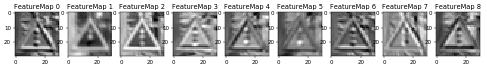

Layer 1 activation: 


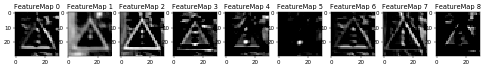

Layer 1 pooling: 


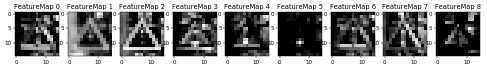

Layer 2 convolution: 


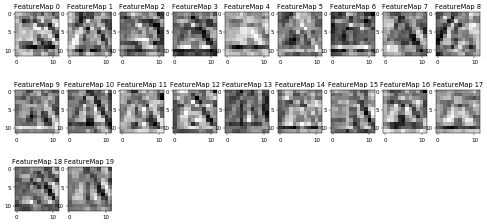

Layer 2 activation: 


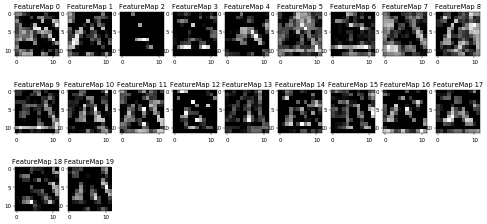

Layer 3 convolution: 


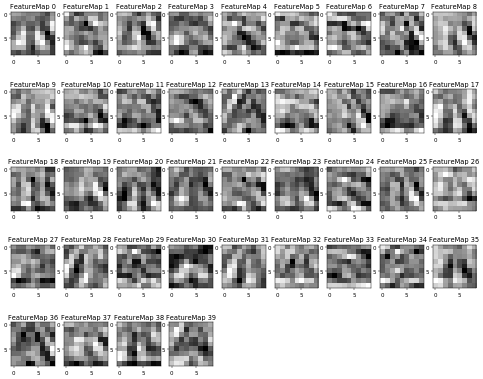

Layer 3 activation: 


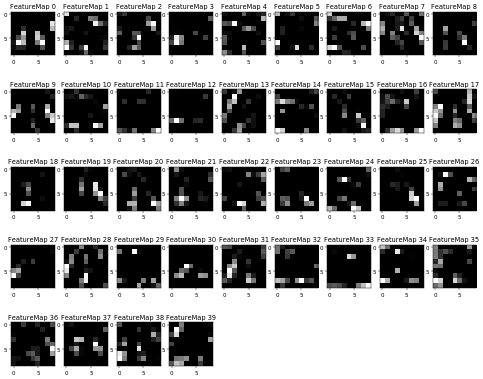

Layer 3 pooling: 


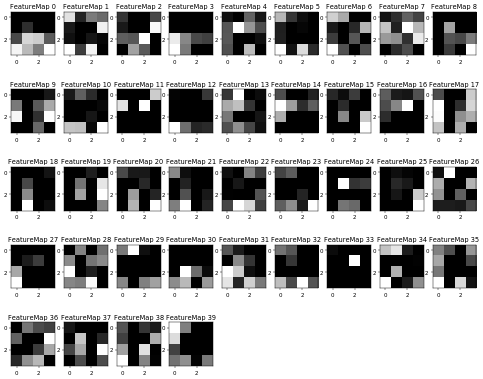

In [65]:
saved_dpi, mpl.rcParams['figure.dpi'] = mpl.rcParams['figure.dpi'], 40

network, x, covnet_layers = build_classification_network(SELECTED_EXPERIMENT)

with tf.Session() as sess:
    load_model(SELECTED_EXPERIMENT, sess)
    labels = sess.run(network, feed_dict={x: X_german[1][0:0,:,:,:]})

    for plt_idx, (layer_name, layer_variable) in enumerate(covnet_layers):
        print("{}: ".format(layer_name))
        outputFeatureMap(X_german[1], layer_variable, plt_num=plt_idx+1, show=True)
mpl.rcParams['figure.dpi'] = saved_dpi